## learning-AI101 : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 U-net을 통한 Encoder-Decoder 방식의 classification

<br>

- **임규연 (lky473736)**
- 2024.08.04., 2024.08.23. ~ 2024.09.01.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. **U-net을 이용한다.**

In [15]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [16]:
# records 병합

import glob

directory_path = '../../data/harth'

# 모든 CSV 파일의 경로를 가져오기
all_files = glob.glob(directory_path + "/*.csv")

print (all_files)

# 데이터프레임을 담을 빈 리스트 생성
df_list = []

# 모든 파일을 순회하며 데이터프레임에 추가
for filename in all_files :
    df = pd.read_csv(filename)  
    df_list.append(df) 

merged_df = pd.concat(df_list, ignore_index=True) # 병합 (header는 ignore)
df = merged_df

df.head()

['../../data/harth/S016.csv', '../../data/harth/S017.csv', '../../data/harth/S029.csv', '../../data/harth/S015.csv', '../../data/harth/S014.csv', '../../data/harth/S028.csv', '../../data/harth/S010.csv', '../../data/harth/S013.csv', '../../data/harth/S012.csv', '../../data/harth/S006.csv', '../../data/harth/S023.csv', '../../data/harth/S022.csv', '../../data/harth/S008.csv', '../../data/harth/S020.csv', '../../data/harth/S021.csv', '../../data/harth/S009.csv', '../../data/harth/S025.csv', '../../data/harth/S019.csv', '../../data/harth/S018.csv', '../../data/harth/S024.csv', '../../data/harth/S026.csv', '../../data/harth/S027.csv']


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,index,Unnamed: 0
0,2019-01-12 00:00:00.000,-0.982201,-0.031251,0.178300,-0.935149,0.006160,-0.358898,6,NaN,NaN
1,2019-01-12 00:00:00.020,-0.973421,-0.042747,0.190618,-0.934986,0.040489,-0.366376,6,NaN,NaN
2,2019-01-12 00:00:00.040,-0.977409,-0.033531,0.185584,-0.939761,0.028617,-0.370106,6,NaN,NaN
3,2019-01-12 00:00:00.060,-0.974620,-0.034506,0.188868,-0.939667,0.036060,-0.369624,6,NaN,NaN
4,2019-01-12 00:00:00.080,-0.976828,-0.041577,0.186524,-0.946145,0.030512,-0.363411,6,NaN,NaN


In [17]:
# timestamp, index 삭제, unnamed 삭제

try : 
    del df['timestamp']
    del df['index']
except : 
    pass

df.drop(['Unnamed: 0'], axis = 1, inplace = True)
print ("현재 attribute : ", df.columns)

현재 attribute :  Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [18]:
# df의 크기 및 info
print("df 크기 : ", df.shape)
df.info()

df 크기 :  (6461328, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   back_x   float64
 1   back_y   float64
 2   back_z   float64
 3   thigh_x  float64
 4   thigh_y  float64
 5   thigh_z  float64
 6   label    int64  
dtypes: float64(6), int64(1)
memory usage: 345.1 MB


In [19]:
# target의 class 도수를 확인 (숫자로)

df['label'].value_counts()

label
7      2902703
1      1197155
6       743480
8       428898
13      393963
2       291356
3       254839
4        76217
5        67253
14       55814
130      41785
140       7865
Name: count, dtype: int64

In [20]:
# # iterrows를 사용하여 각 행에 접근

# for index, row in df.iterrows() :
#     compo_label = df.at[index, 'label']
    
#     if compo_label == 13 :
#         df.at[index, 'label'] = 9
        
#     elif compo_label == 14 : 
#         df.at[index, 'label'] = 10
        
#     elif compo_label == 130 : 
#         df.at[index, 'label'] = 11
        
#     elif compo_label == 140 : 
#         df.at[index, 'label'] = 12

df['label'] = df['label'].replace({13: 9, 14: 10, 130: 11, 140: 12})

for_0_based = dict()
for i in range (12) : 
    for_0_based[i+1] = i
    
df['label'] = df['label'].replace(for_0_based)

# label 열의 고유값을 출력
print (df['label'].unique())


[ 5  2  0  6  1  7  4  3  8 10  9 11]


In [21]:
# input과 target으로 split

harth_input = df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].to_numpy() 
harth_target = df['label'].to_numpy()

# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split
# 또한, X_train, y_train, X_val, y_val로 train set, validation set 각각 8:2로 split

X_train, X_test, y_train, y_test = train_test_split(harth_input, harth_target, 
                                                   stratify=harth_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                        test_size=0.2, 
                                                        stratify=y_train)

In [22]:
# StandardScaler을 통한 정규화 진행

ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

In [23]:
# reshape

X_train_unet = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_unet = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_val_unet = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

X_train_unet.shape, X_test_unet.shape, X_val_unet.shape

((4135249, 6, 1), (1292266, 6, 1), (1033813, 6, 1))

----

###  U-net

- U-Net은 원래 이미지 분할을 위해 설계된 합성곱 신경망(CNN)이지만, 시계열 데이터와 같은 데이터에도 적용할 수 있다.
- X_train_scaled를 conv1D에 대입 가능한 3차원 데이터로 reshape 후에 대입한다.
- **encoder** 
    - input의 important feature를 캡처하기 위해 여러 개의 합성곱 층과 맥스풀링 층으로 구성됨
    - 이 과정에서 입력 데이터는 다운샘플링되며, 특징 맵의 크기가 점점 줄어듬
    - 예시
      ```python
      conv_1 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
      pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
      dropout_1 = keras.layers.Dropout(0.3)(pooling_1)

      conv_2 = keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(dropout_1)
      pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
      dropout_2 = keras.layers.Dropout(0.3)(pooling_2)
      ```

- **decoder**
    - 이 경로는 업샘플링과 합성곱 층을 통해 원본 데이터의 해상도를 복원함
    - 수축 경로에서 얻은 특징을 결합하여 최종 출력 이미지를 생성함.
    - 예시
      ```python
      conv_3 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_2)
      upsampling_1 = keras.layers.UpSampling1D(2)(conv_3)
      ```
      
<br>

<img src='https://miro.medium.com/v2/resize:fit:1358/0*IYsBMfBEIQGiY88r.png' width='500px'>
<img src='https://i.imgur.com/2MUbGYf.png' width='500px'>

**U-net을 정확히 이해하기 위해서 위 U-net 이미지 figure만 보고 직접 modeling하였다. 그로 인하여 거의 3일이 넘는 시간 동안 U-net modeling에만 시간을 투자했다. 아래는 그 시행착오의 흔적이다.**

- 기존에는 bottleneck이 1024개의 노드를 지니게 만들었으나, ETA가 기하급수적으로 늘어나 감당할 수 없음을 판단 후, 128개의 노드를 지니게 재구성하였다.
- 구현 도중, 다음과 같은 문제에 봉착하였다.
    - **문제 1 : U-Net 2D 모델을 1D로 변형**
      - **문제** : 원래는 2D로 구현하였으나, 2D로 reshape하여 U-net을 구성하면 pooling layer가 음수 차원으로 도달하는 문제가 있었다.
      - **해결 방법** : 2D 레이어를 1D 레이어로 변경하고, 커널 크기와 풀링 사이즈를 1D에 맞게 조정하여 unet_1d 모델을 만들었다.

    - **문제 2 : 입력 데이터의 크기 문제**
      - **문제** : 1D 데이터이지만 `height = 1`과 `width`를 맞춰서 `reshape`해야 하였다.
      - **해결 방법** : 데이터를 `(height, width, channels)` 형태로 `reshape`하여 모델에 맞게 조정하였다. 따라서 input data의 형태는 (records 갯수, feature 갯수, 1)이다.

    - **문제 3 : MaxPooling1D에서 음수 차원 크기 오류**
      - **문제** : `MaxPooling1D` 연산이 데이터의 차원을 너무 작게 만들어서 오류가 발생하였다.
      - **해결 방법** : 새로운 시도를 하였다. MaxPooling1D를 사용하는 이유는 중요 feature를 뽑아내기 위함인데, 이를 conv1D의 stride를 이용하여 feature map의 크기를 줄이도록 하였다.

    - **문제 4 : 디코더와 인코더의 비대칭성**
      - **문제** : 디코더 부분이 인코더와 대칭이 되지 않았다. concatenate할 때 size 문제 때문에 제대로 compile이 되지 않는 문제가 발생하였다.
      - **해결 방법** : 각 디코더 단계에서 인코더의 출력과 맞춰서 업샘플링 및 `concatenate`의 오류를 해결하기 위하여 zero padding layer와 cropping layer을 추가하여 tensor의 크기를 맞추었다.

이전 unet_1d_custom 함수의 구성은 encoder에서부터 node의 수가 증가한 후, decoder에서 다시 node의 수가 대칭적으로 감소하는 형태였으나, 이는 U-net의 일반적인 형태가 아님을 인지한 뒤에 다시 수정한다. 수정하기 전의 model figure은 아래와 같다.

<br>

<img src='./model_prev.png' width='200px'>

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 conv1d_18 (Conv1D)          (None, 6, 128)               512       ['input_2[0][0]']             
                                                                                                  
 conv1d_19 (Conv1D)          (None, 6, 128)               49280     ['conv1d_18[0][0]']           
                                                                                                  
 conv1d_20 (Conv1D)          (None, 3, 128)               49280     ['conv1d_19[0][0]']           
                                                                                            

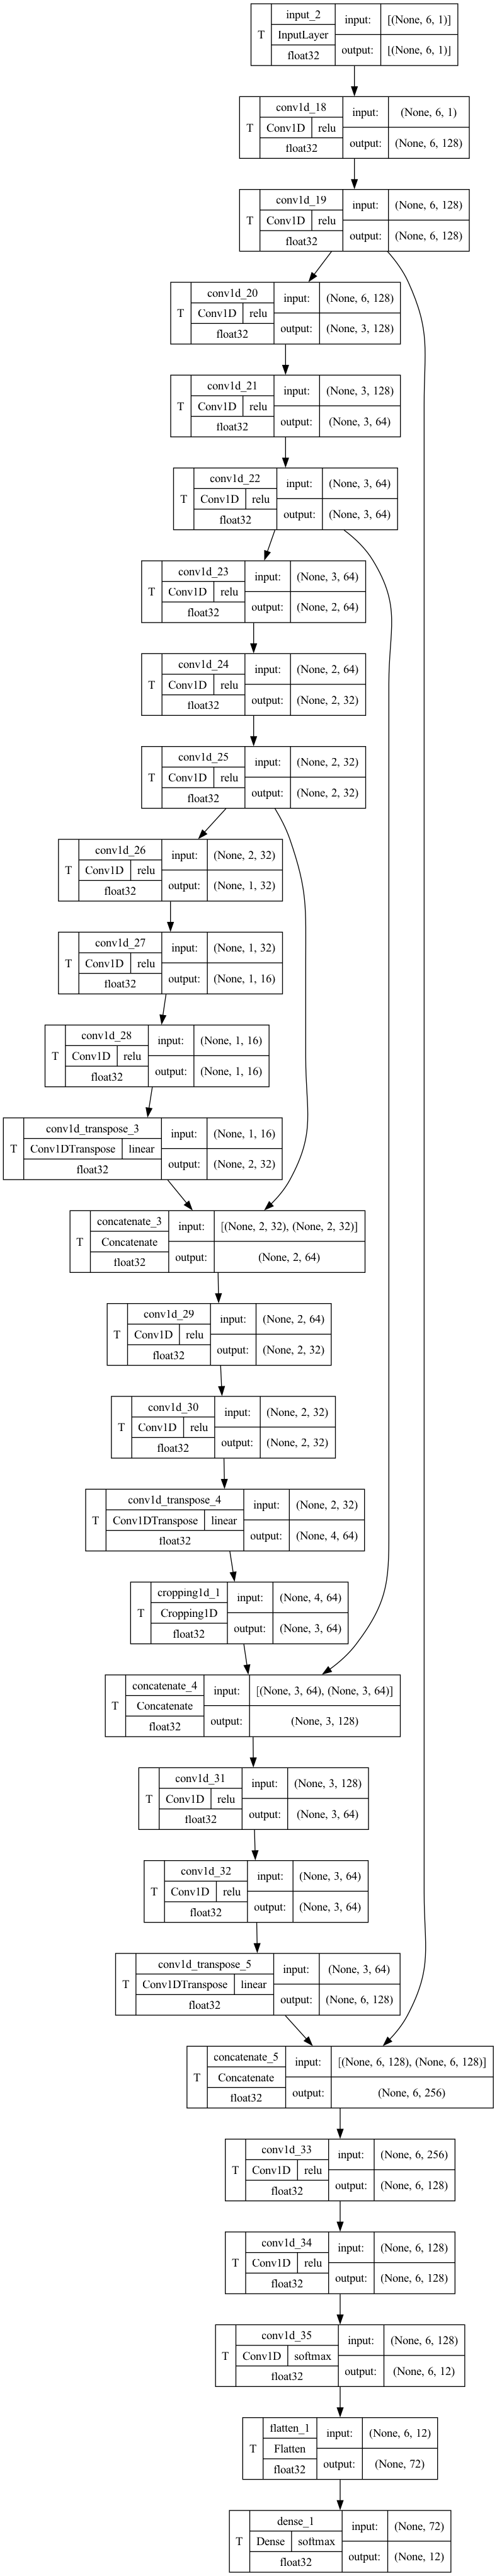

In [24]:
'''
    이전 모델 수정
    - 이전 모델은 encoder-bottleneck의 노드 수가 증가, bottleneck-decoder의 노드 수가 감소 (대칭) <-- 잘못된 형태
'''

from tensorflow.keras import layers, models

def unet_1d_custom(input_shape, num_classes) :
    inputs = layers.Input(shape=input_shape)
    
    # 인코더
    c1 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = layers.Conv1D(128, kernel_size=3, strides=2, activation='relu', padding='same')(c1)  # 다운샘플링

    c2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = layers.Conv1D(64, kernel_size=3, strides=2, activation='relu', padding='same')(c2)  # 다운샘플링

    c3 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = layers.Conv1D(32, kernel_size=3, strides=2, activation='relu', padding='same')(c3)  # 다운샘플링

    # 보틀넥
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(p3)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(b1)

    # 디코더
    u3 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(b1)  # 업샘플링
    
    if u3.shape[1] != c3.shape[1] :
        diff = c3.shape[1] - u3.shape[1]
        
        if diff > 0 :
            u3 = layers.ZeroPadding1D(padding=(0, diff))(u3)
            
        else :
            u3 = layers.Cropping1D(cropping=(0, -diff))(u3)
            
    u3 = layers.concatenate([u3, c3], axis=-1)  # 인코더와 연결
    c7 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u3)
    c7 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c7)

    u4 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(c7)  # 업샘플링
    if u4.shape[1] != c2.shape[1] :
        diff = c2.shape[1] - u4.shape[1]
        
        if diff > 0 :
            u4 = layers.ZeroPadding1D(padding=(0, diff))(u4)
            
        else :
            u4 = layers.Cropping1D(cropping=(0, -diff))(u4)
            
    u4 = layers.concatenate([u4, c2], axis=-1)  # 인코더와 연결
    c8 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c8 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c8)

    u5 = layers.Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(c8)  # 업샘플링
    if u5.shape[1] != c1.shape[1] :
        diff = c1.shape[1] - u5.shape[1]
        
        if diff > 0 :
            u5 = layers.ZeroPadding1D(padding=(0, diff))(u5)
            
        else :
            u5 = layers.Cropping1D(cropping=(0, -diff))(u5)
            
    u5 = layers.concatenate([u5, c1], axis=-1)  # 인코더와 연결
    c9 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(u5)
    c9 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(c9)

    # 출력층 
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(c9)
    outputs = layers.Flatten()(outputs)
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

# 모델 생성
input_shape = (6, 1)  # 길이 6, 채널 1인 입력 데이터
num_classes = 12
model = unet_1d_custom(input_shape=input_shape, num_classes=num_classes)

model.summary()
keras.utils.plot_model(model, show_dtype=True,
                      show_layer_activations=True,
                      show_layer_names=True,
                      show_shapes=True,
                      show_trainable=True)

In [25]:
# compile

from tensorflow.keras.losses import SparseCategoricalCrossentropy

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss=SparseCategoricalCrossentropy(from_logits=False), 
              metrics='accuracy')

In [26]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_unet, y_train, epochs=100, 
                    validation_data=(X_val_unet, y_val), 
                    callbacks=early_stopping_cb, 
                    batch_size=512,
                    verbose=True)

Epoch 1/100
4823/8077 [================>.............] - ETA: 3:55 - loss: 0.4927 - accuracy: 0.8551

KeyboardInterrupt: 

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate

model.evaluate(X_val_unet, y_val)

In [ ]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

y_val_pred = model.predict(X_val_unet)
y_test_pred = model.predict(X_test_unet)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

In [ ]:
# Visualization using Seaborn
# Confusion Matrix for Validation Data
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion Matrix for Test Data
plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
